# Generate manuscript figures

In [1]:
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import joblib
import glob
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.stats as stats

import math


In [3]:
from heritability_model_interpretable import ModelSum

In [4]:
parameters = {'pdf.fonttype':42}
plt.rcParams.update(parameters)

In [5]:
res_path = '../results/heritability_072522/'
# res_path = '../results/heritability_071722/'


res_df = pd.DataFrame()
for file in list(glob.glob(res_path + '*.pkl')):
    ms = joblib.load(file)
    ms.populate_pset_vars()
    cdf = pd.DataFrame({'pset':ms.pset, 'simnum':ms.simnum, 'data_type':ms.data_type,
                            'rho':ms.rho, 'pve':ms.pve,'maf_frac':ms.maf_frac, 'obs':ms.obs, 'k':ms.k, 
                        'overlap':ms.overlap, 'class_imbalance':ms.class_imbalance}, index={'{}.{}'.format(ms.pset, ms.simnum)})
    for mod in ms.real_class_auc.keys():
        # right now, just using mean across all CVs
        cdf['{}_real_class_auc'.format(mod)]=np.mean(ms.real_class_auc[mod])
        cdf['{}_rand_class_auc'.format(mod)]=np.mean(ms.rand_class_auc[mod])
        if ms.real_interp_auc[mod][0] is not None:
            cdf['{}_real_interp_auc'.format(mod)]=np.mean(ms.real_interp_auc[mod])
            cdf['{}_rand_interp_auc'.format(mod)]=np.mean(ms.rand_interp_auc[mod])
        
    res_df = res_df.append(cdf)
    

In [6]:
# res_df.to_csv('../results/heritability_model/summary_results.csv', index=False)

# Plot results

In [7]:
res_df = res_df.fillna(value=np.nan)
res_df['k']=res_df['k'].round(5)

rsubdf = res_df[(res_df['data_type']=='simulation')&(res_df['class_imbalance']==0.5)].groupby(['pset'])

mean_df = rsubdf.mean()
ci_df = 1.96 * rsubdf.std()/np.sqrt(rsubdf.count())

In [8]:
def format_axs(ax, xlabel='Heritability (pve)', ylabel='Cross. Val. AUC', legend=False, fontmin=10):
    if legend:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), fontsize=fontmin, loc='upper left',frameon=False)

    ax.set_xlabel(xlabel, fontsize=fontmin+5)
    ax.set_ylabel(ylabel, fontsize=fontmin+5)
    
    ax.set_ylim([0.3, 1])
    ax.xaxis.set_tick_params(labelsize=fontmin)
    ax.yaxis.set_tick_params(labelsize=fontmin)

## Figure 2

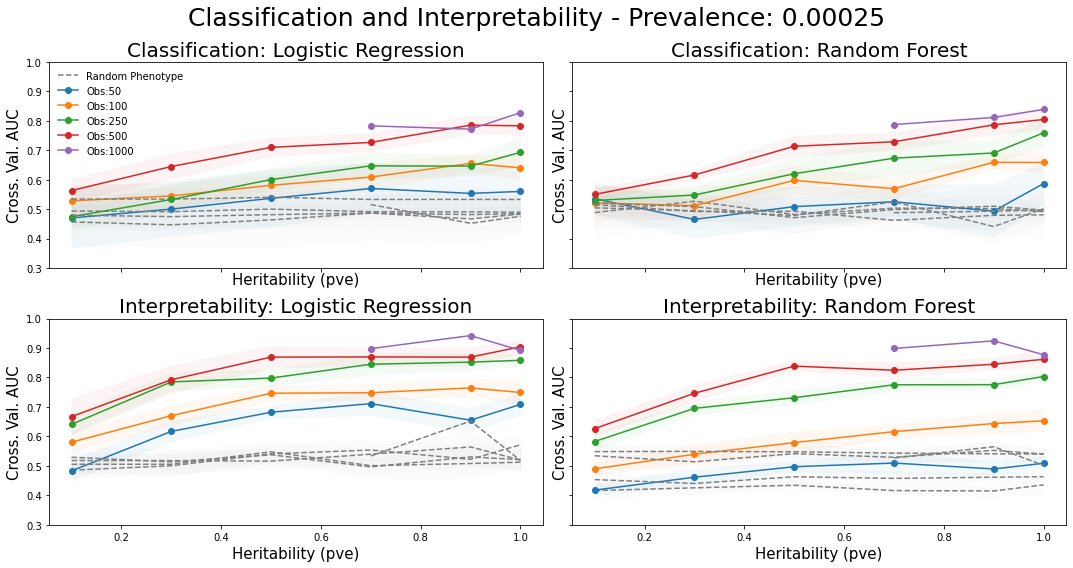

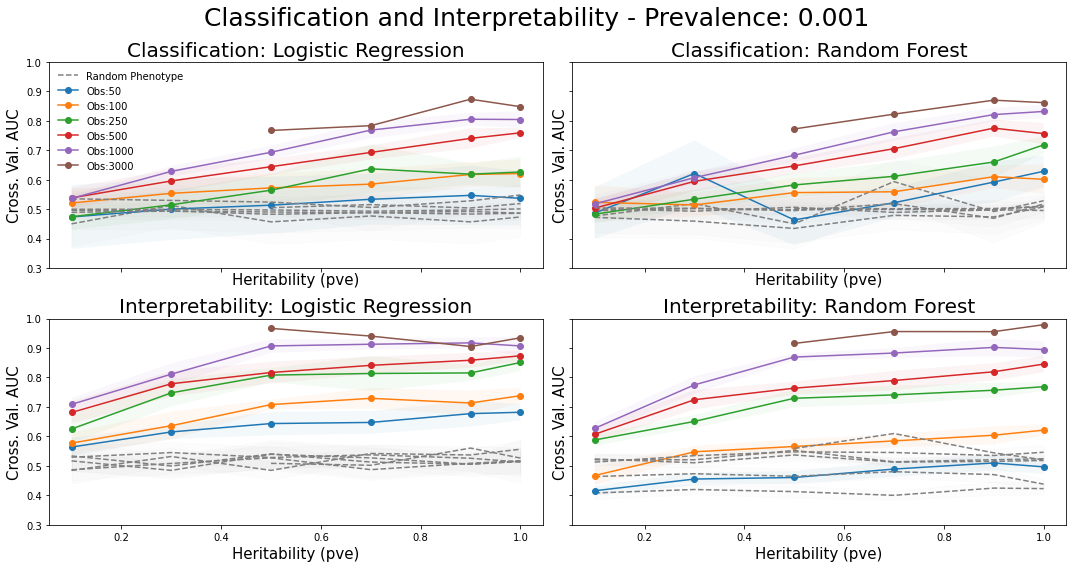

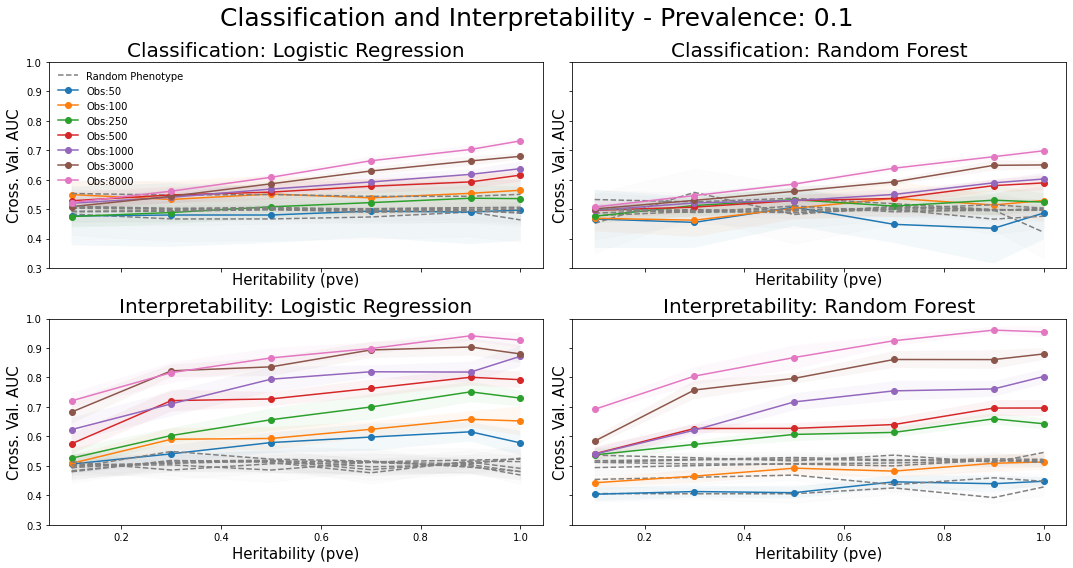

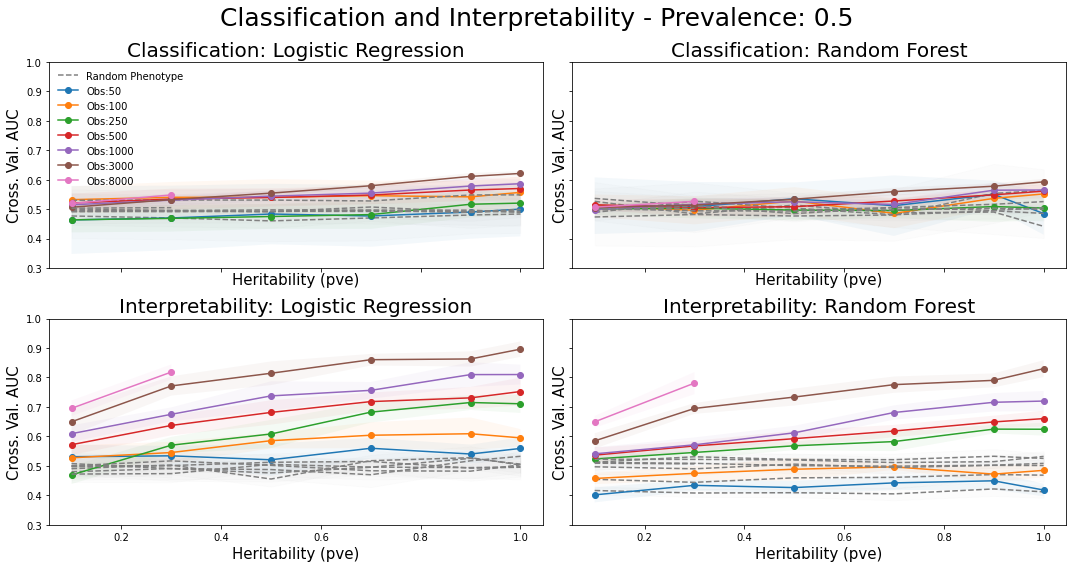

In [9]:
# Figure 2 for plots

# Visualization: x axis:  heritability (pve); y_axis:  score, line=obs (real vs random)
# For each K (ALS, diabetes, common, make plot)
# overlap-logreg, non-overlap-logreg, overlap-rf, nonoverlap-rf
klist = [0.00025, 0.001, 0.1, 0.5]

for k in klist:
    over = False
    mlabel = {'log_reg': 'Logistic Regression', 'rand_forest':'Random Forest', 
              'class': 'Classification', 'interp':'Interpretability'}

    fig, axs = plt.subplots(2,2, figsize=(15,8), sharex=True, sharey=True)
    _ =fig.suptitle('Classification and Interpretability - Prevalence: {}'.format(k), fontsize=25)
    over=False
    mean_df_k = mean_df[(mean_df['k']==k) & (mean_df['overlap']==over) & (mean_df['class_imbalance']==0.5)].copy()
    mean_df_k = mean_df_k.sort_values(by=['obs', 'pve'])

    for i, task in enumerate(['class', 'interp']):
        for j, mod in enumerate(['log_reg', 'rand_forest']):
            for obs in mean_df_k['obs'].unique():
                mean_df_k_o = mean_df_k[(mean_df_k['obs']==obs)]
                ci_df_k_o = ci_df.loc[mean_df_k_o.index]


                _ = axs[i,j].plot(mean_df_k_o['pve'], mean_df_k_o['{}_rand_{}_auc'.format(mod, task)], '--', color='gray', label='Random Phenotype')
                _ = axs[i,j].plot(mean_df_k_o['pve'], mean_df_k_o['{}_real_{}_auc'.format(mod, task)], '-o', label='Obs:{}'.format(int(obs)))

                ci_up = mean_df_k_o['{}_real_{}_auc'.format(mod, task)] + ci_df_k_o['{}_real_{}_auc'.format(mod, task)] 
                ci_low = mean_df_k_o['{}_real_{}_auc'.format(mod, task)] - ci_df_k_o['{}_real_{}_auc'.format(mod, task)] 
                _ = axs[i,j].fill_between(mean_df_k_o['pve'], ci_up, ci_low, alpha=.05)


                ci_up = mean_df_k_o['{}_rand_{}_auc'.format(mod, task)] + ci_df_k_o['{}_rand_{}_auc'.format(mod, task)] 
                ci_low = mean_df_k_o['{}_rand_{}_auc'.format(mod, task)] - ci_df_k_o['{}_rand_{}_auc'.format(mod, task)] 
                _ = axs[i,j].fill_between(mean_df_k_o['pve'], ci_up, ci_low, color='gray', alpha=.02)


                _ = axs[i,j].set_title('{}: {}'.format(mlabel[task], mlabel[mod]), fontsize=20)
                if (i==0)&(j==0):
                    format_axs(axs[i,j], legend=True)
                else:
                    format_axs(axs[i,j], legend=False)
        fig.tight_layout()

        fig.savefig('../reports/fig_class_interp_pve_{}.pdf'.format(k))

    


In [10]:
# print stats for text

mean_df[(mean_df['pve']==1)&(mean_df['k']==0.001)&(mean_df['overlap']==False)&(mean_df['obs']==50)]['log_reg_real_class_auc']
mean_df[(mean_df['pve']==1)&(mean_df['k']==0.001)&(mean_df['overlap']==False)&(mean_df['obs']==1000)]['log_reg_real_class_auc']

mean_df[(mean_df['pve']==1)&(mean_df['k']==0.001)&(mean_df['overlap']==False)&(mean_df['obs']==50)]['log_reg_real_interp_auc']
mean_df[(mean_df['pve']==1)&(mean_df['k']==0.001)&(mean_df['overlap']==False)&(mean_df['obs']==1000)]['log_reg_real_interp_auc']

pset
non_overlap_degree-4-ind-1e+06-tot_snp_sim-5000-frac_causal-0.1-k-0.001-obs-50-maf_frac-0.05-pve-1-rho-0.5    0.536667
Name: log_reg_real_class_auc, dtype: float64

pset
non_overlap_degree-4-ind-1e+06-tot_snp_sim-5000-frac_causal-0.1-k-0.001-obs-1000-maf_frac-0.05-pve-1-rho-0.5    0.80412
Name: log_reg_real_class_auc, dtype: float64

pset
non_overlap_degree-4-ind-1e+06-tot_snp_sim-5000-frac_causal-0.1-k-0.001-obs-50-maf_frac-0.05-pve-1-rho-0.5    0.681985
Name: log_reg_real_interp_auc, dtype: float64

pset
non_overlap_degree-4-ind-1e+06-tot_snp_sim-5000-frac_causal-0.1-k-0.001-obs-1000-maf_frac-0.05-pve-1-rho-0.5    0.907078
Name: log_reg_real_interp_auc, dtype: float64

## Figure 3

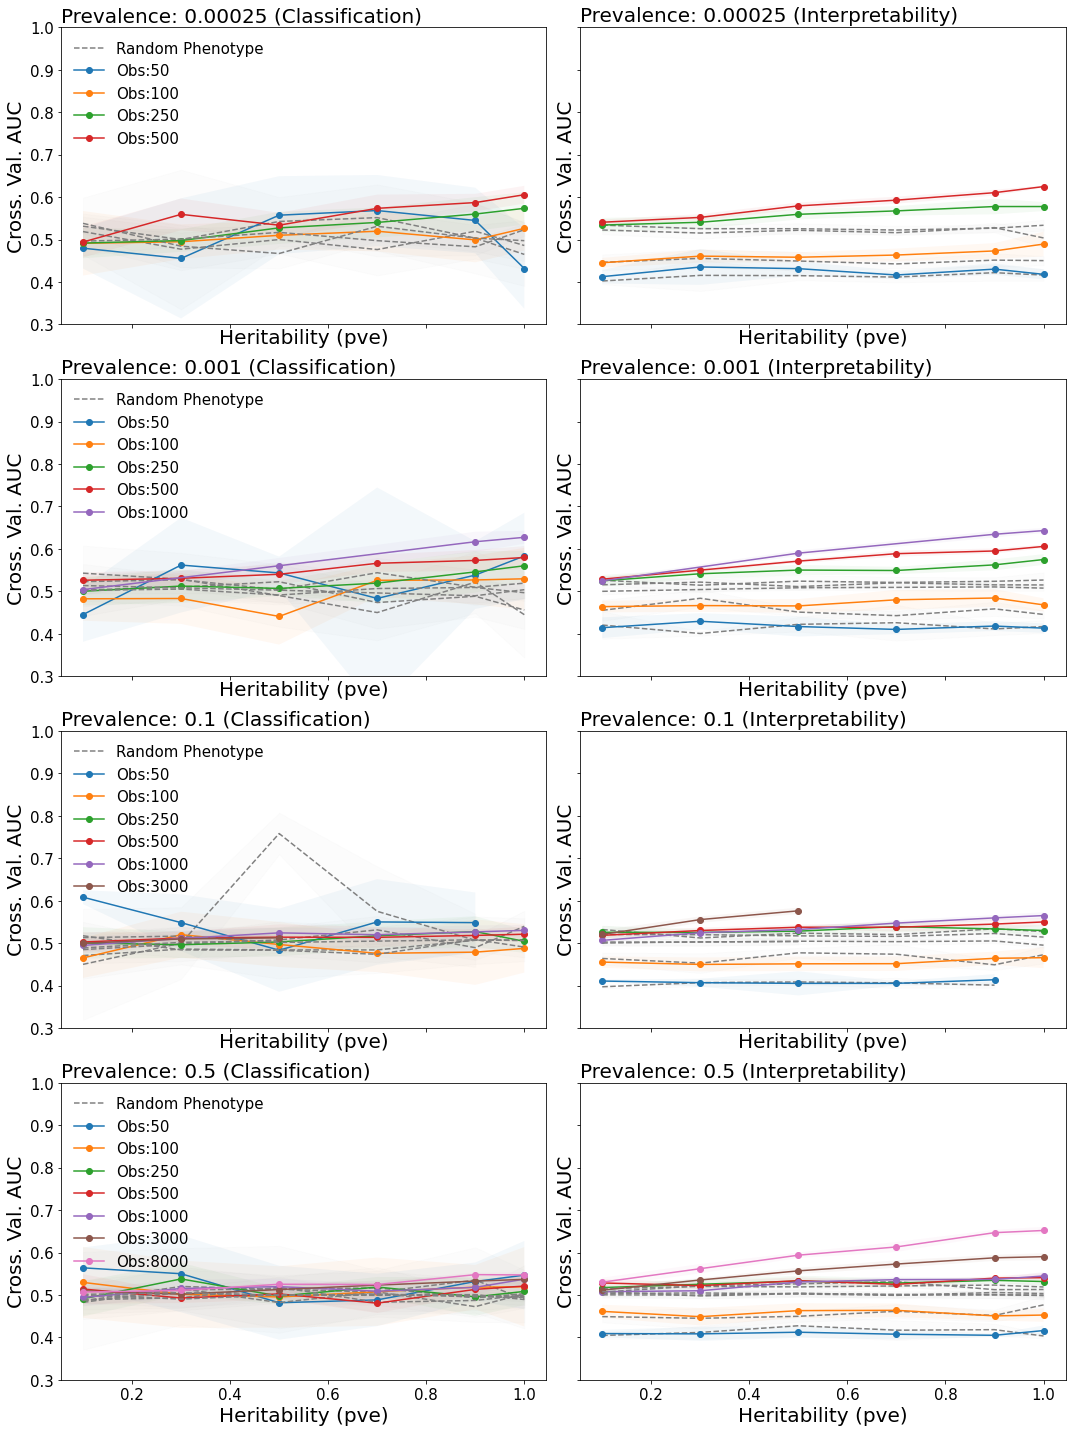

In [20]:
# Visualization: x axis:  heritability (pve); y_axis:  score, line=obs (real vs random)
# For each K (ALS, diabetes, common, make plot)
# overlap-logreg, non-overlap-logreg, overlap-rf, nonoverlap-rf
klist = [0.00025, 0.001, 0.1, 0.5]
mod='log_reg'
# mod='rand_forest'


over = True

fig, axs = plt.subplots(4,2, figsize=(15,20), sharex=True, sharey=True)
mlabel = {'log_reg': 'Logistic Regression', 'rand_forest':'Random Forest', 
              'class': 'Classification', 'interp':'Interpretability'}

for j, k in enumerate(klist):
#     _ =fig.suptitle('Overlapping Simulation - Prevalence: {}'.format(k), fontsize=25)
    mean_df_k = mean_df[(mean_df['k']==k) & (mean_df['overlap']==over) & (mean_df['class_imbalance']==0.5)].copy()
    mean_df_k = mean_df_k.sort_values(by=['obs', 'pve'])

    for i, task in enumerate(['class', 'interp']):
        for obs in mean_df_k['obs'].unique():
            mean_df_k_o = mean_df_k[(mean_df_k['obs']==obs)]
            ci_df_k_o = ci_df.loc[mean_df_k_o.index]


            _ = axs[j,i].plot(mean_df_k_o['pve'], mean_df_k_o['{}_rand_{}_auc'.format(mod, task)], '--', color='gray', label='Random Phenotype')
            _ = axs[j,i].plot(mean_df_k_o['pve'], mean_df_k_o['{}_real_{}_auc'.format(mod, task)], '-o', label='Obs:{}'.format(int(obs)))

            ci_up = mean_df_k_o['{}_real_{}_auc'.format(mod, task)] + ci_df_k_o['{}_real_{}_auc'.format(mod, task)] 
            ci_low = mean_df_k_o['{}_real_{}_auc'.format(mod, task)] - ci_df_k_o['{}_real_{}_auc'.format(mod, task)] 
            _ = axs[j,i].fill_between(mean_df_k_o['pve'], ci_up, ci_low, alpha=.05)


            ci_up = mean_df_k_o['{}_rand_{}_auc'.format(mod, task)] + ci_df_k_o['{}_rand_{}_auc'.format(mod, task)] 
            ci_low = mean_df_k_o['{}_rand_{}_auc'.format(mod, task)] - ci_df_k_o['{}_rand_{}_auc'.format(mod, task)] 
            _ = axs[j,i].fill_between(mean_df_k_o['pve'], ci_up, ci_low, color='gray', alpha=.02)
            _ = axs[j,i].set_title('Prevalence: {} ({})'.format(k, mlabel[task]), loc='left', fontsize=20)

            if (i==0):
                format_axs(axs[j,i], legend=True, fontmin=15)
            else:
                format_axs(axs[j,i], legend=False, fontmin=15)
fig.tight_layout()
fig.savefig('../reports/fig_overlap_{}.pdf'.format(mod))

In [26]:
mean_df[(mean_df['k']==0.001)&(mean_df['overlap']==False)&(mean_df['obs']==1000)]['log_reg_real_class_auc'].max().round(2)

mean_df[(mean_df['k']==0.001)&(mean_df['overlap']==True)&(mean_df['obs']==1000)]['log_reg_real_class_auc'].max().round(2)

mean_df[(mean_df['k']==0.001)&(mean_df['overlap']==False)&(mean_df['obs']==1000)]['log_reg_real_interp_auc'].max().round(2)

mean_df[(mean_df['k']==0.001)&(mean_df['overlap']==True)&(mean_df['obs']==1000)]['log_reg_real_interp_auc'].max().round(2)





0.81

0.76

0.92

0.74

In [12]:
# # kc = 0.001
# kc = 0.5
# oc = 3000
# mean_df[(mean_df['pve']==1.0)&(mean_df['k']==kc)&(mean_df['obs']==oc)]['log_reg_real_class_auc']

# # mean_df[(mean_df['pve']==1.0)&(mean_df['k']==kc)&(mean_df['obs']==500)]['rand_forest_real_class_auc']

# mean_df[(mean_df['pve']==1.0)&(mean_df['k']==kc)&(mean_df['obs']==oc)]['log_reg_real_interp_auc']

# # mean_df[(mean_df['pve']==1.0)&(mean_df['k']==kc)&(mean_df['obs']==500)]['rand_forest_real_interp_auc']

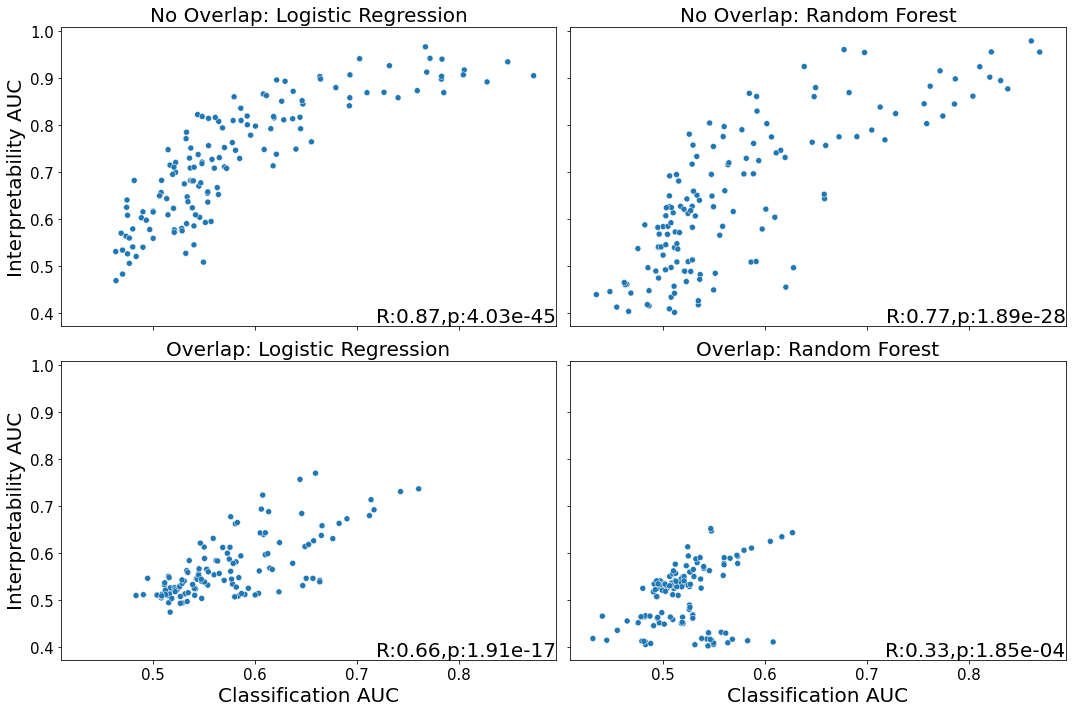

In [13]:
# plot correlation between interpretability auc and classification auc for both LR and RF

fig, axs = plt.subplots(2,2, figsize=(15,10), sharey=True, sharex=True)
mlabel = {'log_reg': 'Logistic Regression', 'rand_forest':'Random Forest', 
              'class': 'Classification', 'interp':'Interpretability', True:'Overlap', False:'No Overlap'}

col_var = 'overlap'

for j, over in enumerate([False, True]):
    mean_df_sub = mean_df[mean_df['overlap']==over]
    for k, mod in enumerate(['log_reg', 'rand_forest']):
        cax = axs[j,k]
        _ = sns.scatterplot(data=mean_df_sub, x='{}_real_class_auc'.format(mod), y='{}_real_interp_auc'.format(mod), ax=cax, hue=col_var)
        _ = cax.set_title('{}: {}'.format(mlabel[over], mlabel[mod]), fontsize=20)
        _ = cax.set_xlabel('Classification AUC', fontsize=20)
        _ = cax.set_ylabel('Interpretability AUC', fontsize=20)

        #  Fit Spearman's R coefficient
        r, p = stats.spearmanr(mean_df_sub['{}_real_class_auc'.format(mod)], mean_df_sub['{}_real_interp_auc'.format(mod)])
        _ = cax.text(1, 0,'R:{:.2f},p:{:.2e}'.format(r, p), ha='right', va='bottom', transform = cax.transAxes, fontsize=20)
        cax.get_legend().remove()
        cax.xaxis.set_tick_params(labelsize=15)
        cax.yaxis.set_tick_params(labelsize=15)

fig.tight_layout()        
fig.savefig('../reports/fig_corr_over.pdf')


In [14]:
# # plot correlation between interpretability auc and classification auc for both LR and RF

# col_var = 'overlap'
# mean_df_sub = mean_df[mean_df['overlap']==False]
# fig, axs = plt.subplots(1,2, figsize=(15,6), sharey=True)
# _ = sns.scatterplot(data=mean_df, x='log_reg_real_class_auc', y='log_reg_real_interp_auc', ax=axs.flat[0], hue=col_var)
# _ = axs.flat[0].set_title('Logistic Regression', fontsize=25)
# _ = axs.flat[0].set_xlabel('Classification AUC', fontsize=20)
# _ = axs.flat[0].set_ylabel('Interpretability AUC', fontsize=20)

# # fig, ax = plt.subplots(figsize=(10,6))
# _ = sns.scatterplot(data=mean_df, x='rand_forest_real_class_auc', y='rand_forest_real_interp_auc', ax=axs.flat[1], hue=col_var)
# _ = axs.flat[1].set_title('Random Forest', fontsize=25)
# _ = axs.flat[1].set_xlabel('Classification AUC', fontsize=20)
# _ = axs.flat[1].set_ylabel('Interpretability AUC', fontsize=20)

# #  Fit Spearman's R coefficient
# for j, m in enumerate(['log_reg', 'rand_forest']):
#     r, p = stats.spearmanr(mean_df['{}_real_class_auc'.format(m)], mean_df['{}_real_interp_auc'.format(m)])
#     _ = axs.flat[j].text(1, 0,'R:{:.2f},p:{:.2e}'.format(r, p), ha='right', va='bottom', transform = axs.flat[j].transAxes, fontsize=20)
    
    

# Real data results

In [15]:
mean_df_disease = res_df[res_df['data_type']=='real'].groupby(['pset']).mean()
mean_df_disease['disease']=[x.split('_')[0] for x in mean_df_disease.index]

res_df['disease']=[x.split('_')[0] for x in res_df.index]

In [16]:
# Compare balancing results for simulation datasets
# res_df[(res_df['data_type']=='simulation')&(res_df['class_imbalance']!=0.5)].groupby('pset').mean()

In [17]:
# res_df['k'].value_counts()

In [18]:
df_search_term_rank = pd.read_csv('/Users/divyar/Documents/Grad - Divya/Research/ltsim/data/df_search_term_rank.csv')
df_search_term_rank_reformatted = pd.read_csv('/Users/divyar/Documents/Grad - Divya/Research/ltsim/data/df_search_term_rank_reformatted.csv')

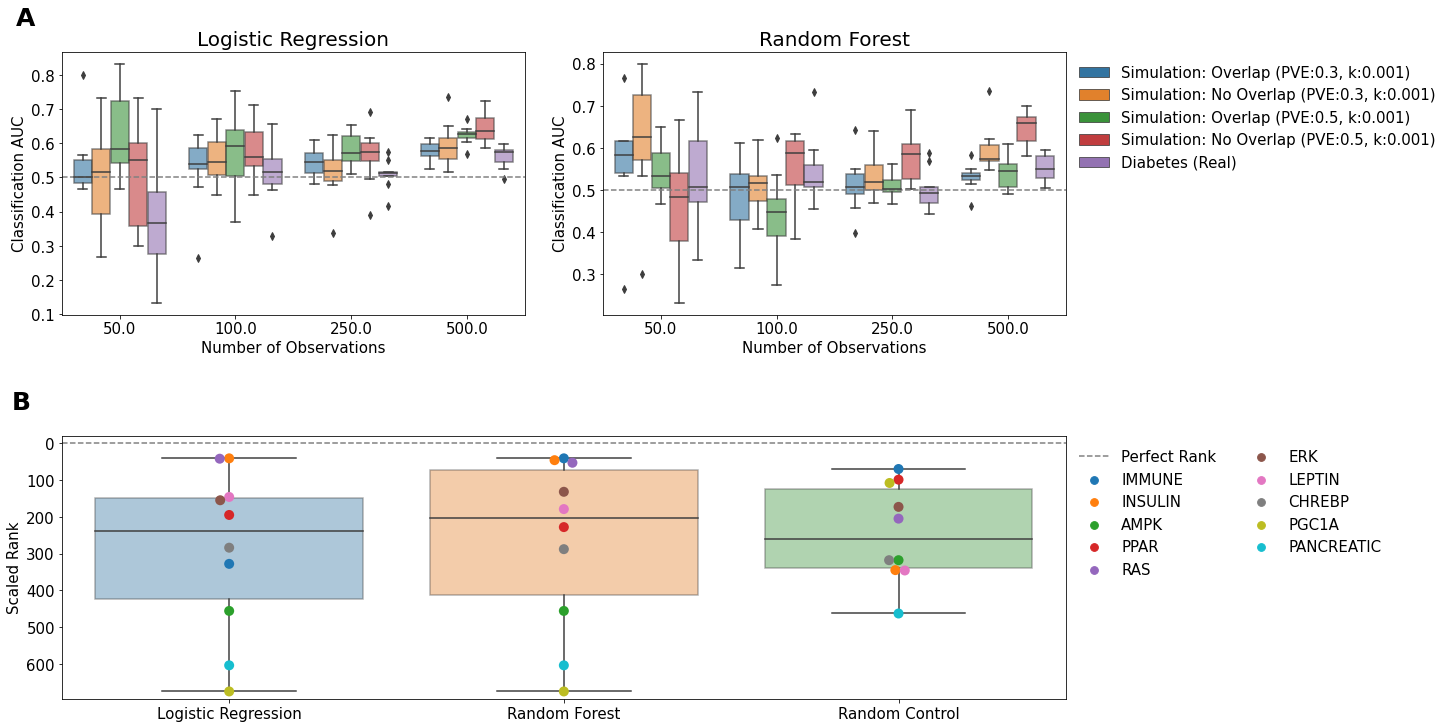

In [19]:
# Compare real data results to simulation for given dataset

# Comparisons:
# - balanced ALS at 1k with balanced simulation at 1k
# - balanced Diabetes at 1k w bal sim at 1k
cdict  = {}
dis = 'diabetes'
kcond = 0.001

fig = plt.figure(figsize=(20,10), constrained_layout=True)
gs = fig.add_gridspec(2,2, hspace=0.1)
f_ax1 = fig.add_subplot(gs[0, 0])
f_ax2 = fig.add_subplot(gs[0,1])
f_ax3 = fig.add_subplot(gs[1, :])
top_axs = [f_ax1, f_ax2]
# fig, axs = plt.subplots(1,2, figsize=(15,6), sharey=True)

for i, mod in enumerate(['log_reg', 'rand_forest']):
    cax = top_axs[i]
    
    simdf_3 = res_df[(res_df['class_imbalance']==0.5)&(res_df['data_type']=='simulation')
                   &(res_df['k']==kcond)&(res_df['pve']==0.3)&(res_df['obs']<=500)].copy()
    simdf_5 = res_df[(res_df['class_imbalance']==0.5)&(res_df['data_type']=='simulation')
                   &(res_df['k']==kcond)&(res_df['pve']==0.5)&(res_df['obs']<=500)].copy()
    disdf = res_df[(res_df['class_imbalance']==0.5)&(res_df['disease']==dis)].copy()
    disdf['overlap']='Diabetes (Real)'
    simdf_3['overlap'] = simdf_3['overlap'].map({True:'Simulation: Overlap (PVE:{}, k:{})'.format(0.3, kcond), False:'Simulation: No Overlap (PVE:{}, k:{})'.format(0.3, kcond)})
    simdf_5['overlap'] = simdf_5['overlap'].map({True:'Simulation: Overlap (PVE:{}, k:{})'.format(0.5, kcond), False:'Simulation: No Overlap (PVE:{}, k:{})'.format(0.5, kcond)})
    df_app = simdf_3.append(simdf_5).append(disdf)
#     df_app['overlap'] = df_app['overlap'].map({True:'sim: overlap', False:'sim: no_overlap', 'real':'real'})

    _ = sns.boxplot(data=df_app, x='obs', y='{}_real_class_auc'.format(mod), hue='overlap', ax=cax,  boxprops=dict(alpha=.6))

    _ = cax.set_xlabel('Number of Observations', fontsize=15)
    _ = cax.set_ylabel('Classification AUC', fontsize=15)
#     _ = axs.flat[i].set_title('{}: {} (k:{})'.format(mlabel[mod], dis, kcond), fontsize=15)
    _ = cax.set_title('{}'.format(mlabel[mod]), fontsize=20)
    _ = cax.xaxis.set_tick_params(labelsize=15)
    _ = cax.yaxis.set_tick_params(labelsize=15)
    _ = cax.axhline(0.5, 0, 50, linestyle='dashed', color='gray')
        
_ = f_ax1.get_legend().remove()
_ = f_ax2.legend(loc='upper left', bbox_to_anchor=(1, 1),frameon=False,fontsize=15)


# plot B
ypoints = 0.2
_ = f_ax3.axhline(ypoints, 0, 1, label='Perfect Rank', color='grey', linestyle='dashed')

_ = sns.boxplot(data=df_search_term_rank, boxprops=dict(alpha=.4), ax=f_ax3)
_ = sns.swarmplot(data=df_search_term_rank_reformatted, x="variable",y="value", size=10, hue="term", edgecolors='b', ax=f_ax3)

max_rank = pd.to_numeric(df_search_term_rank.max(), errors='coerce').max() + 20

_ = f_ax3.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False,fontsize=15, ncol=2)
_ = f_ax3.set_ylim(math.ceil(max_rank), -20)
_ = f_ax3.tick_params(labelsize=15)
_ = f_ax3.set_ylabel('Scaled Rank', fontsize=15)
_ = f_ax3.set_xlabel('')

# Set A and B text
_ = f_ax1.text(-0.1, 1.1, 'A', transform=f_ax1.transAxes, fontsize=25, fontweight='bold')
_ = f_ax3.text(-0.05, 1.1, 'B', transform=f_ax3.transAxes, fontsize=25, fontweight='bold')

fig.savefig('../reports/figures_diabetes.pdf')
